In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
train_data = pd.read_csv("../train.csv")
train_data = train_data.dropna(subset=['gt_25k_p6', 'gt_25k_05_p6', 'md_earn_wne_p10'])

In [3]:
train_data.columns

Index(['INSTNM', 'CITY', 'STABBR', 'PREDDEG', 'CONTROL', 'LOCALE', 'SATVRMID',
       'SATMTMID', 'SATWRMID', 'ACTCMMID', 'ACTENMID', 'ACTMTMID', 'ACTWRMID',
       'SAT_AVG', 'DISTANCEONLY', 'UGDS', 'UGDS_WHITE', 'UGDS_BLACK',
       'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN', 'UGDS_NHPI', 'UGDS_2MOR',
       'UGDS_NRA', 'UGDS_UNKN', 'PPTUG_EF', 'NPT4_PUB', 'NPT4_PRIV', 'PCTPELL',
       'RET_FT4', 'RET_FTL4', 'RET_PT4', 'RET_PTL4', 'PCTFLOAN', 'UG25abv',
       'GRAD_DEBT_MDN_SUPP', 'GRAD_DEBT_MDN10YR_SUPP', 'RPY_3YR_RT_SUPP',
       'C150_4_POOLED_SUPP', 'C200_L4_POOLED_SUPP', 'md_earn_wne_p10',
       'gt_25k_p6', 'gt_25k_05_p6'],
      dtype='object')

# 1

## a

First try predicting the mean value of the response variables to get baseline numbers.

In [4]:
md_earn_mean = train_data["md_earn_wne_p10"].mean()
gt_25k_mean = train_data["gt_25k_05_p6"].mean()
gt_25k_mode = gt_25k_mean >= .5

In [5]:
gt_25k_mode

True

In [6]:
md_earn_MSE = np.mean([(v - md_earn_mean)**2 for v in train_data["md_earn_wne_p10"].values])
gt_25k_MSE = np.mean([(v - gt_25k_mode)**2 for v in train_data["gt_25k_05_p6"].values])

In [7]:
md_earn_MSE

181762616.38489807

In [8]:
gt_25k_MSE

0.46523585960205677

## b

It's the right loss function. Note that 0-1 loss is equivalent to the MSE in the binary classification case.

## c

Let's try covariates related to location, undergraduate demographics, and undergraduate financial situations. We can merge a few of the columns to form single columns pertaining to some of the covariates. Also, we need to make sure to drop rows with NaN values in the covariates we're regressing on!

In [9]:
train_data['NPT4'] = train_data['NPT4_PUB'].combine_first(train_data['NPT4_PRIV'])
train_data['RET_FT'] = train_data['RET_FT4'].combine_first(train_data['RET_FTL4'])
train_data['RET_PT'] = train_data['RET_PT4'].combine_first(train_data['RET_PTL4'])

In [10]:
predictors = ['CONTROL', 'LOCALE', 'UGDS', 'PCTPELL', 'PCTFLOAN', 'UG25abv', 'PPTUG_EF', 'NPT4', 'RET_FT']
train_data = train_data.dropna(subset=predictors)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, _ ,_ = train_test_split(train_data, train_data, test_size=0.25)

In [12]:
for col in X_train.columns:
    r = X_train[col].isna().sum()
    print(col, r)

INSTNM 0
CITY 0
STABBR 0
PREDDEG 0
CONTROL 0
LOCALE 0
SATVRMID 2077
SATMTMID 2067
SATWRMID 2388
ACTCMMID 2062
ACTENMID 2182
ACTMTMID 2181
ACTWRMID 2692
SAT_AVG 2018
DISTANCEONLY 0
UGDS 0
UGDS_WHITE 0
UGDS_BLACK 0
UGDS_HISP 0
UGDS_ASIAN 0
UGDS_AIAN 0
UGDS_NHPI 0
UGDS_2MOR 0
UGDS_NRA 0
UGDS_UNKN 0
PPTUG_EF 0
NPT4_PUB 1844
NPT4_PRIV 1018
PCTPELL 0
RET_FT4 1614
RET_FTL4 1248
RET_PT4 2084
RET_PTL4 1851
PCTFLOAN 0
UG25abv 0
GRAD_DEBT_MDN_SUPP 303
GRAD_DEBT_MDN10YR_SUPP 303
RPY_3YR_RT_SUPP 238
C150_4_POOLED_SUPP 1682
C200_L4_POOLED_SUPP 1319
md_earn_wne_p10 0
gt_25k_p6 0
gt_25k_05_p6 0
NPT4 0
RET_FT 0
RET_PT 1073


Now we'll fit the baseline OLS and logistic regression models.

In [13]:
ols = smf.ols('md_earn_wne_p10 ~ C(CONTROL) + C(LOCALE) + UGDS + PCTPELL + PCTFLOAN + UG25abv + PPTUG_EF', data=X_train).fit()

In [14]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        md_earn_wne_p10   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     160.9
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        19:00:01   Log-Likelihood:                -29858.
No. Observations:                2862   AIC:                         5.975e+04
Df Residuals:                    2843   BIC:                         5.987e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           4.02e+04    730.730     55.015      0.000    3.88e+04    4.16e+04
C(CONTROL)[T.2]    2058.0235    507.358      4.056      0.000    1063.196    3052.851
C(CONTROL)[T.3]   -7508.2767    560.789    -13.389      0.000   -8607.871   -6408.682
C(LOCALE)[T.12.0] -1051.2559    558.550     -1.882      0.060   -2146.461      43.949
C(LOCALE)[T.13.0] -1730.6389    539.665     -3.207      0.001   -2788.813    -672.465
C(LOCALE)[T.21.0]  -185.1481    454.348     -0.408      0.684   -1076.034     705.738
C(LOCALE)[T.22.0] -1206.2756    987.932     -1.221      0.222   -3143.412     730.861
C(LOCALE)[T.23.0] -3739.0348   1210.977     -3.088      0.002   -6113.518   -1364.552
C(LOCALE)[T.31.0] -2418.3476   1139.904     -2.122      0.034   -4653.470    -183.225
C(LOCALE)[T.32.0] -3729.2877    717.460     -5.198      0.000   -5136.082   -2322.493
C(LOCALE)[T.33.0] -3442.0022    765.192     -4.498      0.000   -4942.389   -1941.616
C(LOCALE)[T.41.0] -2735.4920    753.767     -3.629      0.000   -4213.478   -1257.506
C(LOCALE)[T.42.0] -4056.8975   1231.731     -3.294      0.001   -6472.075   -1641.720
C(LOCALE)[T.43.0] -4927.5747   1646.972     -2.992      0.003   -8156.955   -1698.194
UGDS                  0.2681      0.027     10.016      0.000       0.216       0.321
PCTPELL           -2.907e+04    968.963    -30.006      0.000    -3.1e+04   -2.72e+04
PCTFLOAN           1.598e+04    707.958     22.568      0.000    1.46e+04    1.74e+04
UG25abv            7866.5176    980.454      8.023      0.000    5944.045    9788.990
PPTUG_EF          -6920.2303    834.592     -8.292      0.000   -8556.696   -5283.764
==============================================================================
Omnibus:                      792.291   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3289.349
Skew:                           1.293   Prob(JB):                         0.00
Kurtosis:                       7.571   Cond. No.                     8.57e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
log = smf.logit('gt_25k_05_p6 ~ C(CONTROL) + C(LOCALE) + UGDS + PCTPELL + PCTFLOAN + UG25abv + PPTUG_EF', data=X_train).fit()

Optimization terminated successfully.
         Current function value: 0.414137
         Iterations 7


In [16]:
log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           gt_25k_05_p6   No. Observations:                 2862
Model:                          Logit   Df Residuals:                     2843
Method:                           MLE   Df Model:                           18
Date:                Wed, 01 May 2019   Pseudo R-squ.:                  0.4024
Time:                        19:00:02   Log-Likelihood:                -1185.3
converged:                       True   LL-Null:                       -1983.4
                                        LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0172      0.259      3.924      0.000       0.509       1.525
C(CONTROL)[T.2]      -0.4339      0.192     -2.258      0.024      -0.810      -0.057
C(CONTROL)[T.3]      -2.0261      0.200    -10.121      0.000      -2.418      -1.634
C(LOCALE)[T.12.0]    -0.3476      0.189     -1.837      0.066      -0.718       0.023
C(LOCALE)[T.13.0]    -0.5067      0.187     -2.709      0.007      -0.873      -0.140
C(LOCALE)[T.21.0]    -0.0705      0.149     -0.473      0.636      -0.362       0.221
C(LOCALE)[T.22.0]    -0.5163      0.331     -1.558      0.119      -1.166       0.133
C(LOCALE)[T.23.0]    -0.5799      0.425     -1.365      0.172      -1.412       0.253
C(LOCALE)[T.31.0]    -0.0885      0.416     -0.213      0.831      -0.903       0.726
C(LOCALE)[T.32.0]    -0.4322      0.247     -1.747      0.081      -0.917       0.053
C(LOCALE)[T.33.0]    -0.3132      0.259     -1.210      0.226      -0.820       0.194
C(LOCALE)[T.41.0]    -0.2003      0.241     -0.831      0.406      -0.673       0.272
C(LOCALE)[T.42.0]    -1.5032      0.430     -3.500      0.000      -2.345      -0.661
C(LOCALE)[T.43.0]    -1.2543      0.572     -2.192      0.028      -2.376      -0.133
UGDS               8.229e-05   1.43e-05      5.754      0.000    5.43e-05       0.000
PCTPELL             -10.0174      0.467    -21.439      0.000     -10.933      -9.102
PCTFLOAN              7.4485      0.373     19.969      0.000       6.717       8.180
UG25abv               3.0074      0.336      8.943      0.000       2.348       3.667
PPTUG_EF             -0.7014      0.269     -2.607      0.009      -1.229      -0.174
=====================================================================================
"""

In [17]:
def MSE(preds, labels):
    return np.mean([(v - p)**2 for v,p in zip(labels, preds)])

In [18]:
ols_pred = ols.predict(X_test)
log_pred = log.predict(X_test)
ols_MSE = MSE(X_test["md_earn_wne_p10"].values,ols_pred)
log_MSE = MSE(X_test["gt_25k_05_p6"].values,log_pred)

In [19]:
ols_MSE

61270428.03772642

In [20]:
log_MSE

0.13133097625464762

These results are much better than the baseline models from part a. The OLS MSE decreased by an order of magnitude and the logistic regression MSE increased by almost a factor of four.

# 2

In [21]:
def fitmodel(S,data,response,model='ols'):
    if model == 'ols':
        return smf.ols(response+' ~ '+('+'.join(S) if len(S)>0 else '1'), data=data).fit()
    elif model == 'logit':
        return smf.logit(response+' ~ '+('+'.join(S) if len(S)>0 else '1'), data=data).fit()
    return None
def CV_MSE(response, features, data, folds=20):
    idxs = np.arange(len(data))/int(np.ceil(len(data)/float(folds)))
    idxs = idxs.astype(int)
    
    fs = max(idxs)+1
    mses = np.zeros(fs)
    for f in range(fs):
        mses[f] = ((data[idxs==f][response]
            -
            fitmodel(features,data[idxs!=f],response).predict(data[idxs==f]))**2).mean()
    return mses.mean(), mses.std(ddof=1)/np.sqrt(fs)
def PredError(model, df):
    return ((df['quality'] - model.predict(df))**2).mean()
def rsquaredCV(response, features, data):
    return 1-CV_MSE(response,features,data)[0] / data[response].var()

In [22]:
def fitmodel_regularized(S,data,response,l,L1,model='ols'):
    if model == 'ols':
        return smf.ols(response+' ~ '+('+'.join(S) if len(S)>0 else '1'), data=data).fit_regularized(alpha=l,L1_wt=L1)
    elif model == 'logit':
        return smf.logit(response+' ~ '+('+'.join(S) if len(S)>0 else '1'), data=data).fit_regularized(alpha=l,L1_wt=L1)
    return None

In [23]:
def getaic(lm):
    return -lm.aic
mycriterion = getaic
## forward stepwise
def fwdSW(feat, data, response, model):
    Sfwd = set()
    features = set(feat)
    
    while len(Sfwd)<len(features):
        f = max(features - Sfwd, key = lambda f: mycriterion(fitmodel(Sfwd.union({f}),data,response, model)))
        after = mycriterion(fitmodel(Sfwd.union({f}),data,response, model))
        before = mycriterion(fitmodel(Sfwd,data,response,model))
        if after > before:
            Sfwd = Sfwd.union({f})
        else:
            break
    return Sfwd

def bckwdSW(feat, data, response,model):
    Sbwd = set(feat)
    
    while len(Sbwd)>0:
        f = max(Sbwd, key = lambda f: mycriterion(fitmodel(Sbwd-{f},data,response,model)))
        after = mycriterion(fitmodel(Sbwd-{f},data,response,model))
        before = mycriterion(fitmodel(Sbwd,data,response,model))
        if after > before:
            Sbwd = Sbwd-{f}
        else:
            break
    return Sbwd

def SWboth_calc(features, data, response,model):
    Sfwd = fwdSW(features, data, response,model)
    Sbwd = bckwdSW(features, data, response,model)
    Sboth = Sfwd if mycriterion(fitmodel(Sfwd,data,response,model)) > mycriterion(fitmodel(Sbwd,data,response,model)) else Sbwd
    
    return Sboth

def SWboth(Sfwd, Sbwd,data, response):
    Sboth = Sfwd if mycriterion(fitmodel(Sfwd,data,response)) > mycriterion(fitmodel(Sbwd,data,response)) else Sbwd 
    return Sboth

## Feature Selection

We'll use stepwise regression to get the approximately optimal sets of covariates for the two models.

In [24]:
#covariates = list(set(X_train.columns)-{'md_earn_wne_p10', 'gt_25k_05_p6', 'gt_25k_p6', 'INSTNM'})
covariates = ['C(CONTROL)', 'C(LOCALE)', 'UGDS', 'PCTPELL', 'PCTFLOAN', 'UG25abv', 'PPTUG_EF', 'NPT4', 'RET_FT']
covariates = set(covariates).union({'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_UNKN', 'DISTANCEONLY', 'UGDS_ASIAN', 'UGDS_HISP', 'UGDS_AIAN'})

### Regression

In [25]:
S_ols = SWboth_calc(covariates, X_train, 'md_earn_wne_p10', 'ols')
S_ols

{'C(CONTROL)',
 'NPT4',
 'PCTFLOAN',
 'PCTPELL',
 'PPTUG_EF',
 'UG25abv',
 'UGDS',
 'UGDS_AIAN',
 'UGDS_ASIAN',
 'UGDS_BLACK',
 'UGDS_HISP',
 'UGDS_WHITE'}

In [26]:
selected_ols = smf.ols('md_earn_wne_p10 ~ ' + '+ '.join(S_ols), data=X_train).fit()

In [27]:
selected_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        md_earn_wne_p10   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     289.4
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        19:00:13   Log-Likelihood:                -29658.
No. Observations:                2862   AIC:                         5.934e+04
Df Residuals:                    2848   BIC:                         5.943e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.134e+04   1444.061     28.624      0.000    3.85e+04    4.42e+04
C(CONTROL)[T.2] -1254.2641    507.192     -2.473      0.013   -2248.765    -259.763
C(CONTROL)[T.3] -1.053e+04    538.005    -19.581      0.000   -1.16e+04   -9479.754
UGDS_BLACK      -1.036e+04   1401.621     -7.394      0.000   -1.31e+04   -7614.674
PCTFLOAN         1.188e+04    800.340     14.841      0.000    1.03e+04    1.34e+04
PCTPELL         -2.233e+04   1108.578    -20.143      0.000   -2.45e+04   -2.02e+04
UGDS_WHITE      -1.106e+04   1313.661     -8.420      0.000   -1.36e+04   -8485.557
NPT4                0.4323      0.029     14.722      0.000       0.375       0.490
UGDS_ASIAN       1.264e+04   2874.696      4.398      0.000    7005.663    1.83e+04
UGDS                0.2329      0.025      9.503      0.000       0.185       0.281
UGDS_AIAN       -1.645e+04   2630.872     -6.251      0.000   -2.16e+04   -1.13e+04
PPTUG_EF        -5157.2834    784.578     -6.573      0.000   -6695.681   -3618.886
UGDS_HISP       -8874.9715   1429.409     -6.209      0.000   -1.17e+04   -6072.190
UG25abv          7956.6572    917.156      8.675      0.000    6158.300    9755.015
==============================================================================
Omnibus:                      670.240   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3178.569
Skew:                           1.043   Prob(JB):                         0.00
Kurtosis:                       7.723   Cond. No.                     4.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Classification

In [28]:
S_logit = SWboth_calc(covariates, X_train, 'gt_25k_05_p6', 'logit')
S_logit

Optimization terminated successfully.
         Current function value: 0.659442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687379
  

Optimization terminated successfully.
         Current function value: 0.418468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409444
  

Optimization terminated successfully.
         Current function value: 0.398090
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.392300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.424644
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391016
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391642
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.403737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396057
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391317
  

{'C(CONTROL)',
 'DISTANCEONLY',
 'NPT4',
 'PCTFLOAN',
 'PCTPELL',
 'PPTUG_EF',
 'RET_FT',
 'UG25abv',
 'UGDS',
 'UGDS_AIAN',
 'UGDS_ASIAN',
 'UGDS_BLACK',
 'UGDS_UNKN'}

In [29]:
selected_logit = smf.logit('gt_25k_05_p6 ~ ' + '+ '.join(S_logit), data=X_train).fit()

Optimization terminated successfully.
         Current function value: 0.394509
         Iterations 7


In [30]:
selected_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           gt_25k_05_p6   No. Observations:                 2862
Model:                          Logit   Df Residuals:                     2847
Method:                           MLE   Df Model:                           14
Date:                Wed, 01 May 2019   Pseudo R-squ.:                  0.4307
Time:                        19:00:19   Log-Likelihood:                -1129.1
converged:                       True   LL-Null:                       -1983.4
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1968      0.373      0.527      0.598      -0.535       0.928
C(CONTROL)[T.2]    -1.0141      0.208     -4.879      0.000      -1.422      -0.607
C(CONTROL)[T.3]    -2.7235      0.213    -12.774      0.000      -3.141      -2.306
DISTANCEONLY       -3.4323      2.330     -1.473      0.141      -8.000       1.135
UGDS_BLACK         -1.2482      0.289     -4.315      0.000      -1.815      -0.681
RET_FT             -0.7309      0.352     -2.079      0.038      -1.420      -0.042
PCTFLOAN            6.6143      0.395     16.763      0.000       5.841       7.388
PCTPELL            -8.4852      0.495    -17.133      0.000      -9.456      -7.515
UGDS             7.036e-05   1.38e-05      5.116      0.000    4.34e-05    9.73e-05
UGDS_ASIAN          5.7384      1.040      5.519      0.000       3.700       7.776
NPT4             7.688e-05   1.17e-05      6.555      0.000    5.39e-05    9.99e-05
UGDS_AIAN          -2.2691      1.668     -1.361      0.174      -5.538       1.000
PPTUG_EF           -0.7231      0.284     -2.547      0.011      -1.279      -0.167
UGDS_UNKN           1.8127      0.485      3.734      0.000       0.861       2.764
UG25abv             2.9402      0.346      8.509      0.000       2.263       3.617
===================================================================================
"""

### Evaluation after Feature Selection

In [31]:
selected_ols_pred = selected_ols.predict(X_test)
selected_logit_pred = selected_logit.predict(X_test)
selected_ols_MSE = MSE(X_test["md_earn_wne_p10"].values,selected_ols_pred)
selected_log_MSE = MSE(X_test["gt_25k_05_p6"].values,selected_logit_pred)

In [32]:
selected_ols_MSE

54362987.08462377

In [33]:
selected_log_MSE

0.1285836926861631

These results are a bit better than those from the previous part. It seems that using stepwise regression helped!

## Regularization

In [34]:
L1s, lambdas = [.05*x for x in range(21)], [.5*x for x in range(21)]

In [35]:
L1_best, lambda_best, model_best = -1, -1, None
lambda_MSEs = []
min_error = np.float('inf')
for L1 in L1s:
    for l in lambdas:
        model = fitmodel_regularized(S_ols, X_train, 'md_earn_wne_p10', l, L1, 'ols')
        preds = model.predict(X_test)
        error = MSE(X_test['md_earn_wne_p10'].values, preds)
        if L1 == 0.0:
            lambda_MSEs.append(error)
        if error < min_error:
            min_error = error
            L1_best = L1
            lambda_best = l
            model_best = model

In [36]:
L1_best, lambda_best

(0.0, 0.0)

In [37]:
min_error

54362987.08462379

It seems that no regularization is the best choice for this model. Let's see how regularization affects performance...

In [38]:
import matplotlib.pyplot as plt

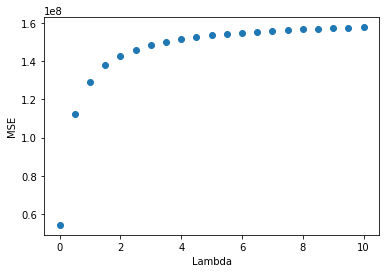

In [39]:
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.scatter(lambdas, lambda_MSEs)

In [40]:
L1_best, lambda_best, model_best = -1, -1, None
lambda_MSEs = []
min_error = np.float('inf')
for L1 in L1s:
    for l in lambdas:
        model = fitmodel_regularized(S_logit, X_train, 'gt_25k_05_p6', l, L1, 'logit')
        preds = model.predict(X_test)
        error = MSE(X_test['gt_25k_05_p6'].values, preds)
        if L1 == 0.0:
            lambda_MSEs.append(error)
        if error < min_error:
            min_error = error
            L1_best = L1
            lambda_best = l
            model_best = model

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3945094603061684
            Iterations: 125
            Function evaluations: 140
            Gradient evaluations: 125
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.400671332504436
            Iterations: 196
            Function evaluations: 211
            Gradient evaluations: 196
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.40614157467442547
            Iterations: 189
            Function evaluations: 204
            Gradient evaluations: 189
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations,

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.41582317959445203
            Iterations: 165
            Function evaluations: 180
            Gradient evaluations: 165
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42030087531847066
            Iterations: 159
            Function evaluations: 174
            Gradient evaluations: 159
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
       

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4361280367690007
            Iterations: 141
            Function evaluations: 156
            Gradient evaluations: 141
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.43958428776332126
            Iterations: 134
            Function evaluations: 149
            Gradient evaluations: 134
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4428442603176419
            Iterations: 133
            Function evaluations: 148
            Gradient evaluations: 133
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4459115446840775
            Iterations: 122
            Function evaluations: 138
            Gradient evaluations: 122
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4488503418347702
            Iterations: 116
     

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4596842519641356
            Iterations: 83
            Function evaluations: 98
            Gradient evaluations: 83
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.46218278844633376
            Iterations: 82
            Function evaluations: 97
            Gradient evaluations: 82
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.46460065465138045
            Iterations: 81
            Function evaluations: 96
            Gradient evaluations: 81
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decrea

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3945094603061684
            Iterations: 125
            Function evaluations: 140
            Gradient evaluations: 125
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.400671332504436
            Iterations: 196
            Function evaluations: 211
            Gradient evaluations: 196
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.40614157467442547
            Iterations: 189
            Function evaluations: 204
            Gradient evaluations: 189
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations,

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42030087531847066
            Iterations: 159
            Function evaluations: 174
            Gradient evaluations: 159
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4245645655436079
            Iterations: 149
            Function evaluations: 164
            Gradient evaluations: 149
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4286207738458245
            Iterations: 153
            Function evaluations: 168
            Gradient evaluations: 153
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4324742047

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.43958428776332126
            Iterations: 134
            Function evaluations: 149
            Gradient evaluations: 134
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4428442603176419
            Iterations: 133
            Function evaluations: 148
            Gradient evaluations: 133
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4459115446840775
            Iterations: 122
            Function evaluations: 138
            Gradient evaluations: 122
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4488503418347702
            Iterations: 116
            Function evaluations: 131
            Gradient evaluations: 116
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.45168995535998696
            Iterations: 110
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.45710362382649944
            Iterations: 86
            Function evaluations: 102
            Gradient evaluations: 86
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4596842519641356
            Iterations: 83
            Function evaluations: 98
            Gradient evaluations: 83
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            C

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3945094603061684
            Iterations: 125
            Function evaluations: 140
            Gradient evaluations: 125
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.400671332504436
            Iterations: 196
            Function evaluations: 211
            Gradient evaluations: 196
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.40614157467442547
            Iterations: 189
            Function evaluations: 204
            Gradient evaluations: 189
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations,

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42030087531847066
            Iterations: 159
            Function evaluations: 174
            Gradient evaluations: 159
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4245645655436079
            Iterations: 149
            Function evaluations: 164
            Gradient evaluations: 149
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4286207738458245
            Iterations: 153
            Function evaluations: 168
            Gradient evaluations: 153
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4324742047

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.43958428776332126
            Iterations: 134
            Function evaluations: 149
            Gradient evaluations: 134
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4428442603176419
            Iterations: 133
            Function evaluations: 148
            Gradient evaluations: 133
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4459115446840775
            Iterations: 122
            Function evaluations: 138
            Gradient evaluations: 122
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4488503418347702
            Iterations: 116
            Function evaluations: 131
            Gradient evaluations: 116
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.45168995535998696
            Iterations: 110
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.45443937910369603
            Iterations: 99
            Function evaluations: 114
            Gradient evaluations: 99
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.45710362382649944
            Iterations: 86
            Function evaluations: 102
            Gradient evaluations: 86
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4596842519641356
            Iterations: 83
            Function evaluations: 98
            Gradient evaluations: 83
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decr

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4669392567702599
            Iterations: 79
            Function evaluations: 94
            Gradient evaluations: 79
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3945094603061684
            Iterations: 125
            Function evaluations: 140
            Gradient evaluations: 125
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.400671332504436
            Iterations: 196
            Function evaluations: 211
            Gradient evaluations: 196
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.406141574674425

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4111229258877041
            Iterations: 170
            Function evaluations: 185
            Gradient evaluations: 170
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.41582317959445203
            Iterations: 165
            Function evaluations: 180
            Gradient evaluations: 165
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4286207738458245
            Iterations: 153
            Function evaluations: 168
            Gradient evaluations: 153
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4324742047431811
            Iterations: 146
            Function evaluations: 161
            Gradient evaluations: 146
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4361280367690007
            Iterations: 141
            Function evaluations: 156
            Gradient evaluations: 141
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.43958428776

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4488503418347702
            Iterations: 116
            Function evaluations: 131
            Gradient evaluations: 116
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.45168995535998696
            Iterations: 110
            Function evaluations: 125
            Gradient evaluations: 110
QC check did not pass for 2 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.45443937910369603
            Iterations: 99
            Function evaluations: 114
            Gradient evaluations: 99
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.45710362382

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.46460065465138045
            Iterations: 81
            Function evaluations: 96
            Gradient evaluations: 81
QC check did not pass for 1 out of 15 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4669392567702599
            Iterations: 79
            Function evaluations: 94
            Gradient evaluations: 79
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3945094603061684
            Iterations: 125
            Function evaluations: 140
            Gradient evaluations: 125
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.400671332504436


In [41]:
L1_best, lambda_best

(0.0, 1.0)

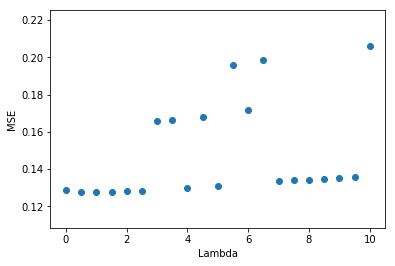

In [42]:
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.scatter(lambdas, lambda_MSEs)

In [43]:
min_error

0.12752103239803397

It's hard to know what to make of this plot right above. It doesn't seem like there's any meaningful relationship between the regularization hyperparameters and the MSE. Let's avoid regularization then.

## Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [45]:
feat_choice, num_trees = ['auto','sqrt','log2'], [10*x for x in range(1, 21)]

In [46]:
feat_choice

['auto', 'sqrt', 'log2']

In [47]:
rf_covariates = (set(covariates)-{'C(LOCALE)', 'C(CONTROL)'})
X_train_features, X_test_features = X_train[list(rf_covariates)], X_test[list(rf_covariates)]

In [48]:
rf_reg = RandomForestRegressor().fit(X_train_features, X_train['md_earn_wne_p10'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
MSE(rf_reg.predict(X_test_features), X_test['md_earn_wne_p10'])

39538586.47798742

In [50]:
feat_best, num_trees_best, model_best = -1, -1, None
min_error = np.float('inf')
MSEs = []
for f in feat_choice:
    for num_t in num_trees:
        model = RandomForestRegressor(max_features=f, n_estimators=num_t).fit(X_train_features, X_train['md_earn_wne_p10'])
        preds = model.predict(X_test_features)
        error = MSE(X_test['md_earn_wne_p10'].values, preds)
        if f == 'auto':
            MSEs.append(error)
        if error < min_error:
            min_error = error
            feat_best = f
            num_trees_best = num_t
            model_best = model

In [51]:
feat_best, num_trees_best

('auto', 120)

In [52]:
MSE(model_best.predict(X_test_features), X_test['md_earn_wne_p10'])

34732226.01327743

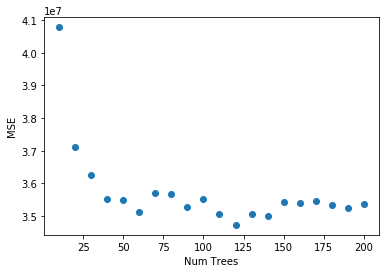

In [53]:
plt.xlabel("Num Trees")
plt.ylabel("MSE")
plt.scatter(num_trees, MSEs)

In [54]:
rf_clf = RandomForestClassifier().fit(X_train_features, X_train['gt_25k_05_p6'])
MSE(rf_clf.predict(X_test_features), X_test['gt_25k_05_p6'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.17819706498951782

In [55]:
feat_best, num_trees_best, model_best = -1, -1, None
min_error = np.float('inf')
MSEs = []
for f in feat_choice:
    for num_t in num_trees:
        model = RandomForestClassifier(max_features=f, n_estimators=num_t).fit(X_train_features, X_train['gt_25k_05_p6'])
        preds = model.predict(X_test_features)
        error = MSE(X_test['gt_25k_05_p6'].values, preds)
        if f == 'auto':
            MSEs.append(error)
        if error < min_error:
            min_error = error
            feat_best = f
            num_trees_best = num_t
            model_best = model

In [56]:
feat_best, num_trees_best

('log2', 180)

In [57]:
MSE(model_best.predict(X_test_features), X_test['gt_25k_05_p6'])

0.1530398322851153

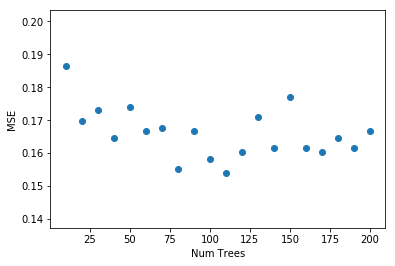

In [58]:
plt.xlabel("Num Trees")
plt.ylabel("MSE")
plt.scatter(num_trees, MSEs)

Let's use grid search with cross validation to get the optimal hyperparameters for our random forest models.

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
parameters = {'n_estimators': num_trees, 'max_features': feat_choice}
grid_reg = GridSearchCV(RandomForestRegressor(), parameters, cv=5)
grid_reg.fit(X_train_features, X_train['md_earn_wne_p10'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
MSE(grid_reg.predict(X_test_features), X_test['md_earn_wne_p10'])

35742176.18114948

In [62]:
grid_reg.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=170, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Using 200 decision trees seems to be the best choice...

In [63]:
parameters = {'n_estimators': num_trees, 'max_features': feat_choice}
grid_clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
grid_clf.fit(X_train_features, X_train['gt_25k_05_p6'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [64]:
MSE(grid_clf.predict(X_test_features), X_test['gt_25k_05_p6'])

0.16457023060796647

In [65]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# 3

In [66]:
test_data = pd.read_csv("../test.csv")
test_data = test_data.dropna(subset=['gt_25k_p6', 'gt_25k_05_p6', 'md_earn_wne_p10'])

In [67]:
test_data['NPT4'] = test_data['NPT4_PUB'].combine_first(test_data['NPT4_PRIV'])
test_data['RET_FT'] = test_data['RET_FT4'].combine_first(test_data['RET_FTL4'])
test_data['RET_PT'] = test_data['RET_PT4'].combine_first(test_data['RET_PTL4'])

In [68]:
predictors = ['CONTROL', 'LOCALE', 'UGDS', 'PCTPELL', 'PCTFLOAN', 'UG25abv', 'PPTUG_EF', 'NPT4', 'RET_FT']
test_data = test_data.dropna(subset=predictors)

In [69]:
test_data.head()

,INSTNM,CITY,STABBR,PREDDEG,CONTROL,LOCALE,SATVRMID,SATMTMID,SATWRMID,ACTCMMID,...,GRAD_DEBT_MDN10YR_SUPP,RPY_3YR_RT_SUPP,C150_4_POOLED_SUPP,C200_L4_POOLED_SUPP,md_earn_wne_p10,gt_25k_p6,gt_25k_05_p6,NPT4,RET_FT,RET_PT
0,Northwest Indian College,Bellingham,WA,2,1,41.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.139551,NaN,28000.0,0.450980,0.0,5790.0,0.2500,NaN
1,University of the Potomac-Washington DC Campus,Washington,DC,3,3,11.0,NaN,NaN,NaN,NaN,...,338.612525,0.422000,NaN,NaN,65400.0,0.748503,1.0,19197.0,0.3333,NaN
5,Huston-Tillotson University,Austin,TX,3,2,11.0,400.0,400.0,NaN,15.0,...,NaN,0.397237,0.253986,NaN,30500.0,0.493590,0.0,17868.0,0.5121,1.0000
7,Nova Southeastern University,Fort Lauderdale,FL,3,2,21.0,530.0,540.0,NaN,24.0,...,294.204325,0.702920,0.410981,NaN,46500.0,0.720637,1.0,27998.0,0.7112,0.2459
9,The Art Institute of Las Vegas,Henderson,NV,3,3,11.0,NaN,NaN,NaN,NaN,...,239.793178,0.289359,0.333376,NaN,25200.0,0.501259,1.0,24679.0,0.5304,0.3902


In [70]:
test_preds_cont = grid_reg.predict(test_data[list(rf_covariates)])

In [71]:
MSE(test_preds_cont, test_data['md_earn_wne_p10'])

41053480.93539597

In [72]:
test_preds_bin = selected_logit.predict(test_data)

In [73]:
MSE(test_preds_bin, test_data['gt_25k_05_p6'])

0.14812830457801876

Our models perform suprisingly well! The test MSE inreased as one would expect, but the scores are comparable overall.